In [ ]:
### To-Do
# 1) make fit_function general enough for pswarms optimization -> dropout rate, layers, nodes, etc
# 2) write function that runs fit_function ~5 times and keeps ensemble + best
# 3) implement pyswarms optimization
# 4) e_sig vs (1-e_bkg) plot
# -) ... 
# N) k-fold validation

In [1]:
# Import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import normalize, to_categorical
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1, l2
from keras.models import load_model
from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

from lbn import LBN, LBNLayer

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

Using TensorFlow backend.


In [2]:
import sys, os
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

topDir = '/home/btannenw/Desktop/ML/dihiggsMLProject/lorentzBoostNetwork/'

In [3]:
#*** 1. Import data and check stuff
testingFraction = 0.3

# *** A. Import Dataset
hh_raw, qcd_raw = importDatasets()

Dihiggs file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/pp2hh4b_500kEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv
QCD file:  /home/btannenw/Desktop/ML/dihiggsMLProject/data/ppTo4b_2MEvents_0PU_v2-05__top4inPt-4tags-10jets_combined_csv.csv


(array([3.3195e+04, 4.0870e+04, 2.5949e+04, 1.1225e+04, 3.8130e+03,
        1.1030e+03, 2.6100e+02, 5.6000e+01, 5.0000e+00, 4.0000e+00]),
 array([ 4. ,  4.9,  5.8,  6.7,  7.6,  8.5,  9.4, 10.3, 11.2, 12.1, 13. ]),
 <a list of 10 Patch objects>)

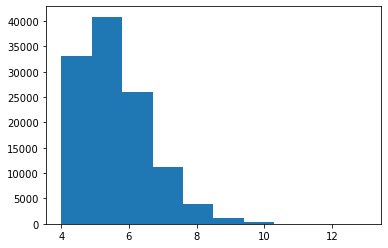

In [4]:
plt.hist(qcd_raw.nJets, bins=10)

In [5]:
# *** 2. Make mix of dihiggs and QCD for specified variables
jetLabels = ['1','2','3','4','5','6','7','8']
jetVariables = ['energy', 'px', 'py', 'pz']
variables_jetVects = ['jet{0}_{1}'.format(iJetLabel, iJetVariable) for iJetLabel in jetLabels for iJetVariable in jetVariables]

# *** 2. Split testing and training
jetVects_data_train, jetVects_data_test, jetVects_labels_train, jetVects_labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, variables_jetVects, testingFraction)

N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [6]:
# *** 2. Create jet vector inputs
def returnJetVectorInputsToLBN(_df, _jetType='jet', _nJets=4):
    
    #flattened
    _allVectorsFlattened = None
    _var = [_jetType+'{}_energy', _jetType+'{}_px', _jetType+'{}_py', _jetType+'{}_pz']
    
    for i in range(1, _nJets + 1):
        _varN = [x.format(i) for x in _var]
        _jetNData = _df[ _varN ].astype(np.float32)
        _vectN = [list(x) for x in _jetNData.values]
        
        if _allVectorsFlattened == None:
            _allVectorsFlattened = _vectN
        else:
            _allVectorsFlattened = [ x + y for x,y in zip(_allVectorsFlattened, _vectN) ]

    return np.array(_allVectorsFlattened)
    

nJets = 8
jetType = 'jet'
trainVectorsByEvent = returnJetVectorInputsToLBN( jetVects_data_train, jetType, nJets)
testVectorsByEvent  = returnJetVectorInputsToLBN( jetVects_data_test, jetType, nJets)

trainLabelsByEvent = np.array([[0.,1.] if x ==0 else [1.,0.] for x in jetVects_labels_train.isSignal]).astype(np.float32)
testLabelsByEvent  = np.array([[0.,1.] if x ==0 else [1.,0.] for x in jetVects_labels_test.isSignal]).astype(np.float32)

print(np.shape(trainVectorsByEvent))

(136749, 32)


In [7]:
# *** 3A. Define LBN model and train
def createModelLBN(_nodesInFirstHiddenLayer=80, _nodesInSecondHiddenLayer=256, _hiddenActivation='relu', _outputActivation='sigmoid', _weightsDir=''):
    """make lbn model"""
    #init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=123)
 
    features = ["E", "pt", "eta", "phi", "m", "pair_dr"]
    lbn_layer = LBNLayer(n_particles=5, boost_mode="pairs", features=features)
    
    
    metrics = [
        tf.keras.metrics.categorical_accuracy,
        tf.keras.metrics.AUC(name='auc'),
    ]
    
    #l2_reg = l2(1e-4)
    
    l2_reg = tf.keras.regularizers.l2(1e-4)
    
    dense_kwargs_IML = dict(
        activation="selu",
        kernel_initializer=tf.keras.initializers.lecun_normal(),
        kernel_regularizer=l2_reg,
    )

    dense_kwargs = dict(
        activation=_hiddenActivation,
        kernel_initializer=tf.keras.initializers.lecun_normal(),
        kernel_regularizer=l2_reg,
    )

    _model = tf.keras.models.Sequential()

    #_model.add(LBNLayer(5, boost_mode=LBN.PAIRS, features=features))
    _model.add(lbn_layer)
    _model.add(tf.keras.layers.BatchNormalization(axis=1))


    _model.add(tf.keras.layers.Dense(80, **dense_kwargs))#, kernel_regularizer=l2_reg))
    _model.add(tf.keras.layers.Dense(256, **dense_kwargs))#, kernel_regularizer=l2_reg))


    #_model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=init))
    #_model.add(tf.keras.layers.Dense(750, activation='relu'))#, kernel_regularizer=l2_reg))
    #_model.add(tf.keras.layers.Dense(256, activation='relu'))
    #_model.add(tf.keras.layers.Dropout(0.2))
    #_model.add(BatchNormalization())

    #_model.add(tf.keras.layers.Dense(128, activation='relu'))
    #_model.add(tf.keras.layers.Dense(64, activation='relu'))
    #_model.add(tf.keras.layers.Dense(32, activation='relu'))

    _model.add(tf.keras.layers.Dense(2, activation=_outputActivation, kernel_regularizer=l2_reg))
        
    _model.compile(loss='binary_crossentropy',
                  #loss='mean_squared_error',
                  optimizer='adam',
                  metrics = metrics
                 )
    
    if _weightsDir !='':
        
        local_dir = os.path.join(topDir, "lbn", "models", _weightsDir)
        modelfile = os.path.join(local_dir, _weightsDir)+'.hdf5'
        print("++ loading model from {}".format(modelfile))
        #<-- FIXME: this does not check if file exits
    
        _model.predict(np.empty([1,32]))
        _model.load_weights(modelfile)

        
    return _model

In [9]:
def fit_model(_model, name, data=None, validation_data=None, epochs=10, batch_size=512):
   
    model_dir = os.path.join(topDir, "lbn", "models", name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    fit_callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(model_dir, name)+'.hdf5',
            save_best_only=True,
            save_weights_only=True,
            monitor="val_auc",
            mode="max",
            #monitor="val_loss",
            #mode="min",
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_auc",
            mode="max",
            #monitor='val_loss', 
            #mode='min', 
            verbose=1, 
            patience=100, 
            min_delta=.0025,
        ),
    ]

    
    if data is None:
        data = (trainVectorsByEvent, trainLabelsByEvent)
    if validation_data is None:
        validation_data = (testVectorsByEvent, testLabelsByEvent)

    _history = _model.fit(data[0], data[1],
        validation_data=validation_data,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=fit_callbacks,
    )

    return _model, _history



In [10]:
# *** 3A. Do things the proper, functional way

modelName = 'model_1kTrainEpochs'

model = createModelLBN(_outputActivation='sigmoid') # 1.81+/0.06

model, history = fit_model(model, name=modelName, data=(trainVectorsByEvent, trainLabelsByEvent), 
                          validation_data=(testVectorsByEvent, testLabelsByEvent), epochs=1000, batch_size=400)

best_model = createModelLBN(_outputActivation='sigmoid', _weightsDir=modelName)


Train on 136749 samples, validate on 58608 samples
Epoch 1/1000
136749/136749 [==============================] - 11s 83us/sample - loss: 0.6018 - categorical_accuracy: 0.6910 - auc: 0.7662 - val_loss: 0.5546 - val_categorical_accuracy: 0.7297 - val_auc: 0.8111
Epoch 2/1000
136749/136749 [==============================] - 8s 55us/sample - loss: 0.5359 - categorical_accuracy: 0.7434 - auc: 0.8257 - val_loss: 0.5171 - val_categorical_accuracy: 0.7564 - val_auc: 0.8392
Epoch 3/1000
136749/136749 [==============================] - 7s 50us/sample - loss: 0.5074 - categorical_accuracy: 0.7637 - auc: 0.8458 - val_loss: 0.4970 - val_categorical_accuracy: 0.7704 - val_auc: 0.8529
Epoch 4/1000
136749/136749 [==============================] - 9s 64us/sample - loss: 0.4926 - categorical_accuracy: 0.7736 - auc: 0.8558 - val_loss: 0.4859 - val_categorical_accuracy: 0.7754 - val_auc: 0.8593
Epoch 5/1000
136749/136749 [==============================] - 8s 57us/sample - loss: 0.4805 - categorical_accura

Epoch 40/1000
136749/136749 [==============================] - 9s 67us/sample - loss: 0.4079 - categorical_accuracy: 0.8234 - auc: 0.9050 - val_loss: 0.4245 - val_categorical_accuracy: 0.8146 - val_auc: 0.8963
Epoch 41/1000
136749/136749 [==============================] - 9s 66us/sample - loss: 0.4084 - categorical_accuracy: 0.8229 - auc: 0.9048 - val_loss: 0.4254 - val_categorical_accuracy: 0.8139 - val_auc: 0.8957
Epoch 42/1000
136749/136749 [==============================] - 9s 66us/sample - loss: 0.4081 - categorical_accuracy: 0.8236 - auc: 0.9050 - val_loss: 0.4193 - val_categorical_accuracy: 0.8187 - val_auc: 0.8992
Epoch 43/1000
136749/136749 [==============================] - 9s 66us/sample - loss: 0.4064 - categorical_accuracy: 0.8246 - auc: 0.9060 - val_loss: 0.4211 - val_categorical_accuracy: 0.8179 - val_auc: 0.8983
Epoch 44/1000
136749/136749 [==============================] - 9s 64us/sample - loss: 0.4070 - categorical_accuracy: 0.8245 - auc: 0.9057 - val_loss: 0.4200 - v

Epoch 79/1000
136749/136749 [==============================] - 8s 59us/sample - loss: 0.3943 - categorical_accuracy: 0.8329 - auc: 0.9130 - val_loss: 0.4188 - val_categorical_accuracy: 0.8207 - val_auc: 0.9007
Epoch 80/1000
136749/136749 [==============================] - 8s 62us/sample - loss: 0.3953 - categorical_accuracy: 0.8316 - auc: 0.9124 - val_loss: 0.4169 - val_categorical_accuracy: 0.8226 - val_auc: 0.9016
Epoch 81/1000
136749/136749 [==============================] - 8s 61us/sample - loss: 0.3952 - categorical_accuracy: 0.8313 - auc: 0.9125 - val_loss: 0.4216 - val_categorical_accuracy: 0.8191 - val_auc: 0.8992
Epoch 82/1000
136749/136749 [==============================] - 8s 57us/sample - loss: 0.3952 - categorical_accuracy: 0.8322 - auc: 0.9126 - val_loss: 0.4224 - val_categorical_accuracy: 0.8181 - val_auc: 0.8987
Epoch 83/1000
136749/136749 [==============================] - 8s 58us/sample - loss: 0.3945 - categorical_accuracy: 0.8316 - auc: 0.9129 - val_loss: 0.4187 - v

Epoch 118/1000
136749/136749 [==============================] - 8s 58us/sample - loss: 0.3878 - categorical_accuracy: 0.8361 - auc: 0.9167 - val_loss: 0.4214 - val_categorical_accuracy: 0.8196 - val_auc: 0.9006
Epoch 119/1000
136749/136749 [==============================] - 8s 58us/sample - loss: 0.3899 - categorical_accuracy: 0.8352 - auc: 0.9156 - val_loss: 0.4263 - val_categorical_accuracy: 0.8190 - val_auc: 0.8992
Epoch 120/1000
136749/136749 [==============================] - 8s 58us/sample - loss: 0.3887 - categorical_accuracy: 0.8359 - auc: 0.9163 - val_loss: 0.4204 - val_categorical_accuracy: 0.8210 - val_auc: 0.9012
Epoch 121/1000
136749/136749 [==============================] - 8s 60us/sample - loss: 0.3900 - categorical_accuracy: 0.8346 - auc: 0.9156 - val_loss: 0.4219 - val_categorical_accuracy: 0.8197 - val_auc: 0.9004
Epoch 122/1000
136749/136749 [==============================] - 8s 59us/sample - loss: 0.3878 - categorical_accuracy: 0.8366 - auc: 0.9167 - val_loss: 0.422

In [ ]:
# *** 3B. Do things "by hand"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=.001)
mc = ModelCheckpoint('best_model.hdf5', #filepath=os.path.join(model_dir, name),
                    monitor="val_loss", mode='min', save_weights_only=True, save_best_only=True)
 

#model = createModelLBN(_outputActivation='softmax') # 1.77+/0.04, 1.84 +/- 0.06
model2 = createModelLBN(_outputActivation='sigmoid') # 1.81+/0.06

history = model2.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=50, validation_data = (testVectorsByEvent, testLabelsByEvent), batch_size=400, callbacks=[es, mc])
#history = model.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=10, validation_data = (testVectorsByEvent, testLabelsByEvent))
print(model2.count_params())

# load the saved model
#model_best = model.load_weights('best_model.h5')

In [ ]:
# *** 3C. Define low-level NN using jet vectors for comparison
model_nn = tf.keras.models.Sequential()
nInputNodes = len(trainVectorsByEvent[0]) 
#model.add(Dense(100, input_dim=nInputNodes, activation='relu'))

model_nn.add(tf.keras.layers.Dense(128, input_dim = nInputNodes, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(BatchNormalization())

model_nn.add(tf.keras.layers.Dense(64, activation='relu'))
model_nn.add(tf.keras.layers.Dense(32, activation='relu'))
model_nn.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model_nn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_nn = model_nn.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=50, validation_data = (testVectorsByEvent, testLabelsByEvent), batch_size=400)
#history = model.fit( trainVectorsByEvent, trainLabelsByEvent, epochs=10, validation_data = (testVectorsByEvent, testLabelsByEvent))
print(model_nn.count_params())

In [10]:
# *** 4. Do some very specific evaluation based on pure samples
hh_data_test, hh_labels_test, qcd_data_test, qcd_labels_test = returnTestSamplesSplitIntoSignalAndBackground(testVectorsByEvent, testLabelsByEvent)

#score_hh = model.evaluate(np.array(hh_data_test), np.array(hh_labels_test))
#score_qcd = model.evaluate(np.array(qcd_data_test), np.array(qcd_labels_test))
#print(score_hh, score_qcd)

pred_hh = best_model.predict(np.array(hh_data_test))
pred_qcd = best_model.predict(np.array(qcd_data_test))

++ loading model from /home/btannenw/Desktop/ML/dihiggsMLProject/lorentzBoostNetwork/lbn/models/model_test/model_test.hdf5
(58608, 2)


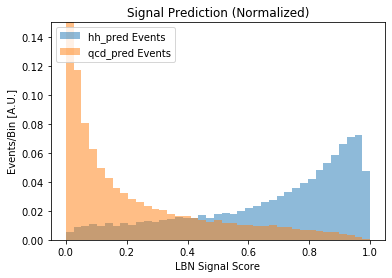

In [11]:
_nBins = 40
predictionResults = {'hh_pred':pred_hh[:,0], 'qcd_pred':pred_qcd[:,0]}
compareManyHistograms( predictionResults, ['hh_pred', 'qcd_pred'], 2, 'Signal Prediction', 'LBN Signal Score', 0, 1, _nBins, _yMax = 5, _normed=True, _savePlot=False )


In [12]:
# *** 4. Get best cut value for ff-NN assuming some minimal amount of signal
returnBestCutValue('ff-NN', pred_hh[:,0].copy(), pred_qcd[:,0].copy(), _minBackground=200, _testingFraction=testingFraction)

23724 34884
nSig = 1346.2512 , nBkg = 578844.46 with significance = 1.7694779815193677 +/- 0.05968728783558154 for ff-NN score > 0.9088708541610023


(1.7694779815193677, 0.9088708541610023)

In [ ]:
# *** 5. Get signifiance for any user-specified NN score cut value
lumiscale_hh  = getLumiScaleFactor(testingFraction, True)
lumiscale_qcd = getLumiScaleFactor(testingFraction, False)
cut = 0.81
_nSignal = sum( value > cut for value in pred_hh)*lumiscale_hh
_nBackground = sum( value > cut for value in pred_qcd)*lumiscale_qcd

print('nSig = {0} , nBkg = {1} with significance = {2} for NN score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), cut) )

dict_keys(['loss', 'categorical_accuracy', 'auc', 'val_loss', 'val_categorical_accuracy', 'val_auc'])


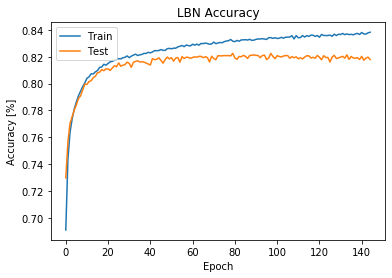

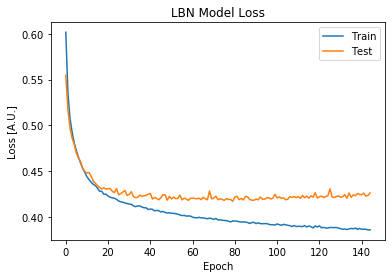

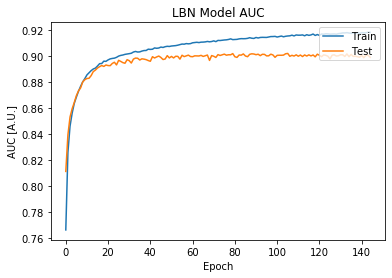

In [11]:
# *** 6. Make some training diagnostic plots
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('LBN Accuracy')
plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LBN Model Loss')
plt.ylabel('Loss [A.U.]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('LBN Model AUC')
plt.ylabel('AUC [A.U.]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
model.summary()

In [ ]:
# ROC curve and AUC
testVectorsByEvent_ROC = testVectorsByEvent.copy()
#top10_data_test_ROC = top10_data_test__norm.copy()
#top10_data_test_ROC = top10_data_test_ROC.drop('isSignal', axis=1)

y_pred = model.predict(testVectorsByEvent_ROC).ravel()
falsePositiveRate, truePositiveRate, thresholds = roc_curve(testLabelsByEvent, y_pred)
auc_keras = auc(falsePositiveRate, truePositiveRate)

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(falsePositiveRate, truePositiveRate, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()